In [1]:
%matplotlib inline

In [2]:
import pddp
import pddp.examples

In [3]:
import torch

In [4]:
import matplotlib.pyplot as plt

In [5]:
def plot_variance(Z, encoding, indices=None, std_scale=1.0):
    mean_ = pddp.utils.encoding.decode_mean(Z, encoding)
    std_ = pddp.utils.encoding.decode_std(Z, encoding)
        
    if indices is None:
        indices = list(range(mean_.shape[-1]))

    plt.figure(figsize=(12, 6))
    plt.xlabel("Time steps")
    t = torch.arange(Z.shape[0]).detach().numpy()
    for index in indices:
        mean = mean_[:, index].detach().numpy()
        std = std_[:, index].detach().numpy()

        _ = plt.plot(t, mean, label="Mean estimate")

        for i in range(1, 4):
            j = std_scale * i
            _ = plt.gca().fill_between(
                t.flat, (mean - j * std).flat, (mean + j * std).flat,
                color="#dddddd", alpha=1.0/i, label="Confidence")
            
    plt.ylim(-5, 5)

    plt.show()

In [6]:
def plot_particles(Xs, indices=None, title="Dynamics rollout"):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    
    if indices is None:
        indices = list(range(Xs.shape[-1]))

    t = torch.arange(Xs.shape[1]).detach().numpy()
    for index in indices:
        for particle in Xs:
            X = particle[:, index].detach().numpy()
            _ = plt.plot(t, X, color="b", alpha=0.05)

    plt.ylim(-5,5)
            
    plt.show()

In [7]:
N = 25  # Horizon length.
DT = 0.1  # Time step (s).
RENDER = False  # Whether to render the environment or not.
ENCODING = pddp.StateEncoding.DEFAULT

In [8]:
cost = pddp.examples.cartpole.CartpoleCost()
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)
true_model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)

In [9]:
controller = pddp.controllers.iLQRController(env, true_model, cost)

In [10]:
U = torch.randn(N, env.action_size)

In [11]:
Z, U = controller.fit(U, encoding=pddp.StateEncoding.IGNORE_UNCERTAINTY, n_iterations=100, tol=1e-2)

/Users/anass/Dev/personal/pddp/pddp/controllers/ilqr.py:172: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


In [12]:
N_PARTICLES = 1000

model = pddp.models.bnn.bnn_dynamics_model_factory(
    env.state_size, env.action_size, [200, 200],
    true_model.angular_indices,
    true_model.non_angular_indices,
)(n_particles=N_PARTICLES)
p_model = pddp.models.bnn.bnn_dynamics_model_factory(
    env.state_size, env.action_size, [200, 200],
    true_model.angular_indices,
    true_model.non_angular_indices,
    particles=True,
)()

In [13]:
dataset, _, _ = pddp.controllers.pddp._train(env, model, cost, U, 1, training_opts={"normalize": False})

In [14]:
z0 = dataset[0][0]
z0 = torch.cat([z0, torch.zeros(10)])
# z0 = pddp.utils.encoding.encode(z0, C=torch.eye(4)*0).requires_grad_()
u = U[0].requires_grad_()

In [15]:
Z = torch.empty(N + 1, z0.shape[0])
P = torch.empty(N_PARTICLES, N + 1, 4)
Z[0] = z0
P[:, 0, :] = z0[:4].repeat(N_PARTICLES, 1)

p_model.model = model.model

for i, u in enumerate(U):
    Z[i + 1] = model(Z[i], u, i, encoding=ENCODING)
    P[:, i+1, :] = p_model(P[:, i, :], u, i)

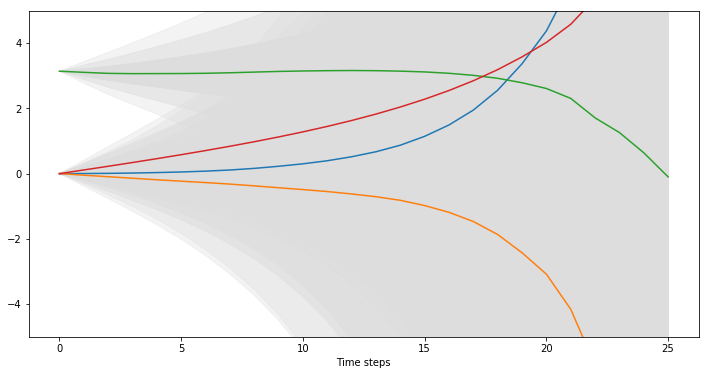

In [16]:
plot_variance(Z, ENCODING)

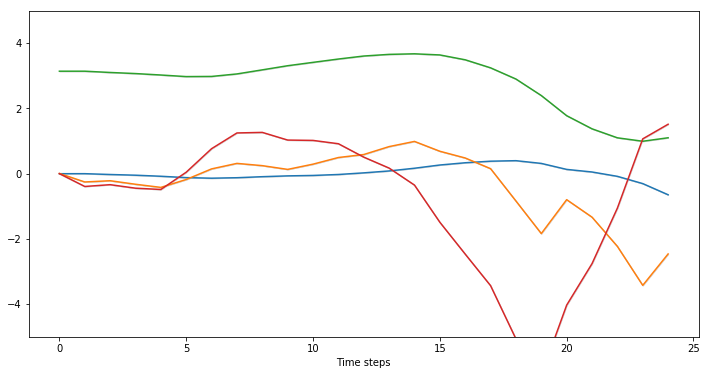

In [17]:
plot_variance(dataset[0], 4, std_scale=0)

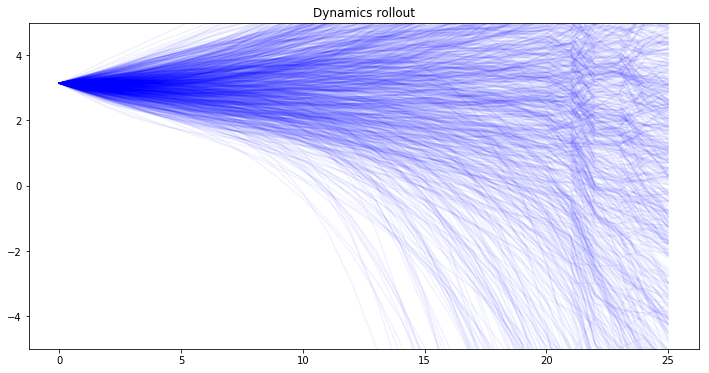

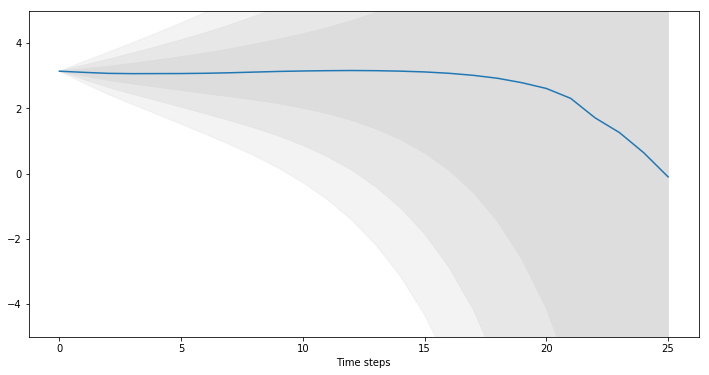

In [18]:
M = P.mean(0)
S = P.std(0)
S[0] += 1e-9
Z__ = pddp.utils.encoding.encode(M, S=S, encoding=ENCODING)
plot_particles(P, [2])
plot_variance(Z__, ENCODING, [2])

In [19]:
DX = {}
INPUTS = {}
Ls = {}

def particles_model(z, u, i):
    mean = z.mean(0)
    std = z.std(0)
    # z = pddp.utils.encoding.encode(mean, S=std, encoding=ENCODING)
    # mean = pddp.utils.encoding.decode_mean(z, encoding=ENCODING)
    # std = pddp.utils.encoding.decode_std(z, encoding=ENCODING)

    deltas = z - mean
    C = deltas.t().mm(deltas) / (z.shape[0] - 1)
    L = C if C.allclose(torch.zeros_like(C)) else C.potrf()
    Ls[i] = L
    
    # x = mean + model.eps_in[i].mm(L)
    x = z

    INPUTS[i] = x
    x_ = pddp.utils.angular.augment_state(x, true_model.angular_indices, true_model.non_angular_indices)
    x_ = torch.cat([x_, u], dim=-1)
    
    x_ = model._normalize_input(x_)
    out = model.model(x_)
    dx, log_std = out.split([mean.shape[-1], mean.shape[-1]], -1)
    dx, log_std = model._scale_output(dx, log_std)
    DX[i] = dx

    return x + dx

In [20]:
P = torch.empty(N_PARTICLES, N + 1, 4)
P[:, 0, :] = z0[:4].repeat(N_PARTICLES, 1)

for i, u in enumerate(U):
    p = P[:, i, :]
    u = u.repeat(N_PARTICLES, 1)
    P[:, i+1, :] = particles_model(p, u, i)

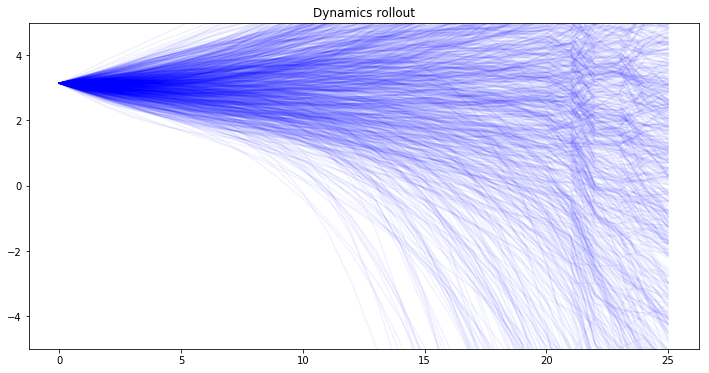

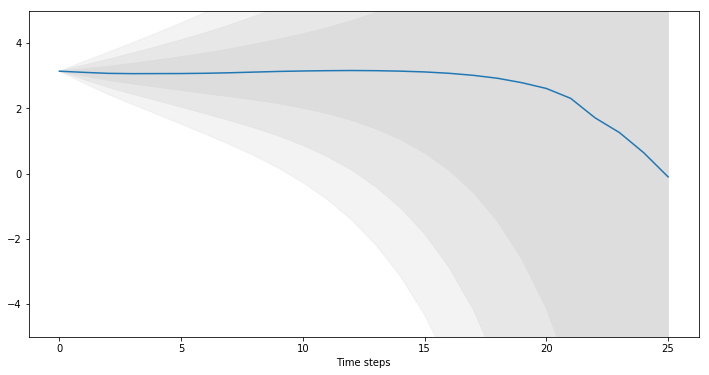

In [21]:
M = P.mean(0)
S = P.std(0)
S[0] += 1e-9
Z__ = pddp.utils.encoding.encode(M, S=S, encoding=ENCODING)
plot_particles(P, [2])
plot_variance(Z__, ENCODING, [2])

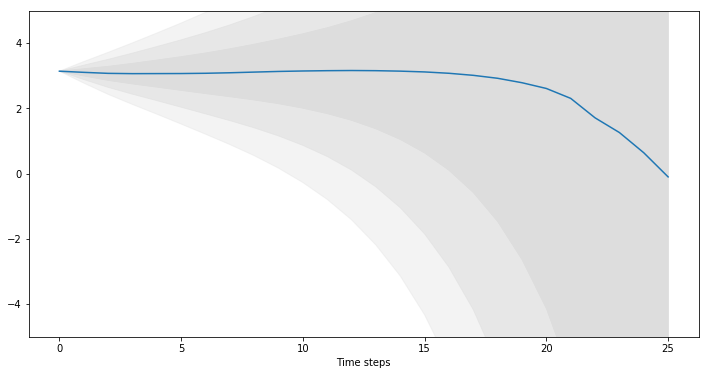

In [22]:
plot_variance(Z, ENCODING, [2])

In [23]:
P.var(0)

tensor([[   0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0115,    0.0125,    0.0120,    0.0101],
        [   0.0486,    0.0497,    0.0460,    0.0401],
        [   0.1171,    0.1139,    0.0990,    0.0895],
        [   0.2264,    0.2105,    0.1717,    0.1597],
        [   0.3939,    0.3516,    0.2666,    0.2558],
        [   0.6433,    0.5544,    0.3872,    0.3826],
        [   1.0062,    0.8423,    0.5381,    0.5473],
        [   1.5336,    1.2502,    0.7294,    0.7633],
        [   2.3093,    1.8362,    0.9770,    1.0526],
        [   3.4678,    2.6937,    1.2997,    1.4473],
        [   5.2168,    3.9591,    1.7312,    1.9928],
        [   7.9115,    5.8528,    2.3286,    2.7558],
        [  12.1588,    8.7498,    3.1747,    3.8386],
        [  18.9918,   13.2401,    4.3846,    5.4028],
        [  30.2336,   20.3591,    6.1663,    7.7198],
        [  49.1123,   31.9653,    8.8421,   11.1945],
        [  81.2364,   51.2473,   12.9100,   16.4787],
        [ 136.7159,   83.460

In [24]:
pddp.utils.encoding.decode_var(Z, ENCODING)

tensor([[   0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0115,    0.0125,    0.0120,    0.0101],
        [   0.0486,    0.0497,    0.0460,    0.0401],
        [   0.1171,    0.1139,    0.0990,    0.0895],
        [   0.2264,    0.2105,    0.1717,    0.1597],
        [   0.3939,    0.3516,    0.2666,    0.2558],
        [   0.6433,    0.5544,    0.3872,    0.3826],
        [   1.0062,    0.8423,    0.5381,    0.5473],
        [   1.5336,    1.2502,    0.7294,    0.7633],
        [   2.3093,    1.8362,    0.9770,    1.0526],
        [   3.4678,    2.6937,    1.2997,    1.4473],
        [   5.2168,    3.9591,    1.7312,    1.9928],
        [   7.9115,    5.8528,    2.3286,    2.7558],
        [  12.1588,    8.7498,    3.1747,    3.8386],
        [  18.9918,   13.2401,    4.3846,    5.4028],
        [  30.2336,   20.3591,    6.1663,    7.7198],
        [  49.1123,   31.9653,    8.8421,   11.1945],
        [  81.2364,   51.2473,   12.9100,   16.4787],
        [ 136.7159,   83.460